In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import unidecode
import gc

In [2]:
%matplotlib inline

# 1. Clustering de texte

## 1.1. Traitements préliminaires

###  1.1.1 Importation de la base de données

In [3]:
with zipfile.ZipFile('Dataset+projet+prétraitement+textes+images.zip', 'r') as folder:
    with folder.open('Flipkart/flipkart_com-ecommerce_sample_1050.csv') as file:
        text_data = pd.read_csv(file)

In [4]:
text_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

### 1.1.2. Extraction des catégories

Notre première étape consiste à identifier des catégories utilisables pour notre classification. Nous remarquons que la colonne `product_categorie_tree` contient des catégories emboîtées les unes dans les autres, de la plus générique à la plus précise. Nous commençons donc par la plus générique.

In [6]:
categories = [re.split('>>', text)[0].replace('["', '').strip()\
              for text in text_data['product_category_tree']]

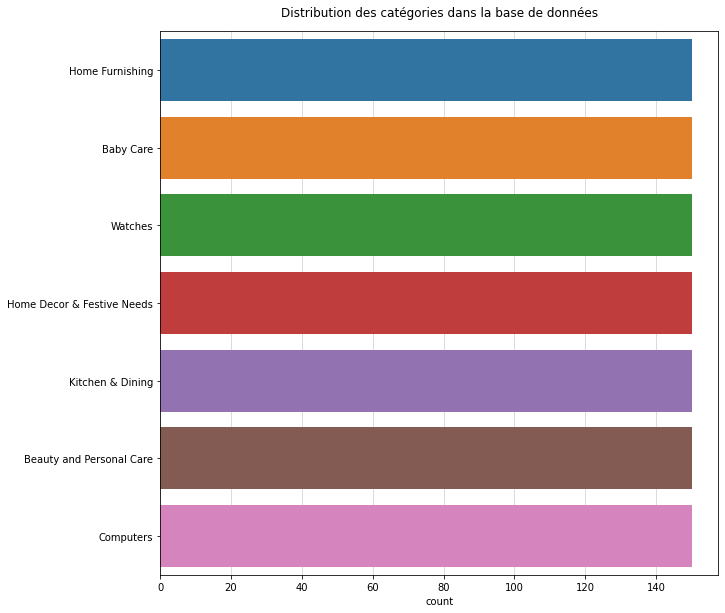

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

sns.countplot(
    y = categories
)

ax.set_title('Distribution des catégories dans la base de données', pad = 15)
ax.grid(visible=True, axis='x', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

In [8]:
print("Les catégories sont les suivantes :")
for cat in set(categories):
    print(f"- {cat} : {sum([cat_val == cat for cat_val in categories])}")

Les catégories sont les suivantes :
- Beauty and Personal Care : 150
- Computers : 150
- Home Decor & Festive Needs : 150
- Home Furnishing : 150
- Baby Care : 150
- Kitchen & Dining : 150
- Watches : 150


Nous pouvons remarquer qu'en utilisant les 7 catégories génériques, la base de données est parfaitement équilibrée. En effet, chaque catégorie contient 150 produits exactement. Nous proposons donc de considérer ces catégories comme nos labels d'origine.

## 1.2. Nettoyage des données de texte

Afin de pouvoir traiter des données de texte, il nous est nécessaire de les normaliser.

In [9]:
text_data['description'].head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

Nous pouvons observer que le texte contient majuscules et minuscules, ainsi que de la ponctuation. Nous devons donc nous assurer que ces éléments sont pris en compte lors de la normalisation.

Nous allons également tenter d'analyser les éléments numériques contenus dans le texte. Pour ce faire, nous procédons par échantillonage pour inférer les formats possibles.

In [10]:
from random import sample

In [11]:
num_values = [re.findall('\S+\s?\d+\s?\S+', text) for text in text_data['description']]
sample(num_values, 10)

[['(330 ml)', 'Rs. 225'],
 ['S3648 Analog',
  'S3648 Analog',
  'S3648 Online',
  'Rs.800 in',
  'Products, 30 Day'],
 ['Rs. 350 from', 'Products. 30 Day'],
 ['Rs. 349 Brand', 'Box 3 Back'],
 ['Rs. 769 Dress', 'Box 3 Bodysuits', 'of 3 Age', 'Group 0 -'],
 ['of 4 SLES',
  'of 4 (500',
  'Rs. 475 Natural',
  'Size: 125 g',
  '(4.4 Oz)',
  'of 4 (500',
  'Quantity 500 g',
  'of 4 Ideal',
  'Pack 1 Composition',
  'Box 4 Soap'],
 ['17.6 cm', 'Rs.699 online.', '17.6 cm', 'Products. 30 Day'],
 ['AST906 Analog',
  'AST906 Analog',
  'AST906 Online',
  'Rs.899 in',
  'Products, 30 Day'],
 ['Rs.175 online.', 'Products. 30 Day'],
 ['Rs. 1299 at']]

Nous remarquons que certains de ces éléments fournissent des informations précises sur le poids, la longueur, la date... Nous proposons d'utiliser des patterns pour remplacer ces éléments par un mot synthétique indiquant l'information apportée.

In [12]:
features_map = {'\d+\s?(g\W|kg)':' weight_info ',
                '\d+\s?(inch|cm|mm|ft)':' length_info ',
                '\d+\s?(hour|day)':' time_info ',
                '\d+\s?(mbps|gb)':' tech_info ',
                '\d+\s?(ml|l\W)':' fluid_info ',
                '(rs\.)\s?\d+':' price_info ',
                '\.com':' website_info '
               }

Nous pouvons désormais créer notre fonction de normalisation, incluant une étape de tokenisation.

In [13]:
def tokenize_with_features_add(string, features_map):
    """Fonction de tokenisation"""
    # Passage en minuscules
    string_lower = string.lower()
    # Remplacement des patterns
    for pat, repl in zip(features_map.keys(), features_map.values()):
        string_lower = re.sub(pat, repl, string_lower)
    # Nettoyage des accents
    string_clean = unidecode.unidecode(string_lower)
    # Suppression des caractères hors lettres
    string_clean = re.sub("[^a-z_]"," ", string_clean)
    # Suppression des multiples espaces
    string_clean = re.sub("\s+"," ", string_clean)
    # Tokenisation
    word_tokens = word_tokenize(string_clean)
    return word_tokens

Il sera également utile, pour certaines approches, d'inclure une étape de simplification des mots. Pour cela, nous proposons d'utiliser une lemmatisation.

In [14]:
def lemmatize(string_list) :
    """Fonction de lemmatisation d'un corpus sous forme de list"""
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in string_list]
    return lem_w

Nous pouvons également retirer les différents mots les plus courants, ou stop-words.

In [15]:
def stopwords_remover(string_list, stop_words):
    """Fonction de suppression des stop words d'un corpus sous forme de list de list de tokens"""
    cleaned_list = [word for word in string_list if word not in stop_words]
    return cleaned_list

In [16]:
def transform_bow_lem_fct(text, stop_words, features_map) :
    """
    Fonction de prétraitement d'un corpus de texte au format list, incluant:
    - tokenisation
    - lemmatisation
    - suppression de stopwords
    """
    word_tokens = tokenize_with_features_add(text, features_map)
    word_tokens_lem = lemmatize(word_tokens)
    word_tokens_cleaned = stopwords_remover(word_tokens_lem, stop_words)       
    transf_desc_text = ' '.join(word_tokens_cleaned)
    return transf_desc_text

Le texte étant en anglais, nous utiliserons les stop-words anglais. A ceux-ci, nous ajoutons le nom du site de vente, Flipkart, celui-ci ne nous apportant pas d'information spécifique, et risquant de se retrouver dans la plupart des articles / liens.

In [17]:
en_sw = stopwords.words('english')
# Ajout du nom du site aux stop words
en_sw.append('flipkart')

Nous pouvons désormais procéder au pré-processing du texte pour les bag of words et tf-idf.

In [18]:
bow_description = text_data['description'].apply(lambda x: transform_bow_lem_fct(x, en_sw, features_map))
bow_description.head()

0    key feature elegance polyester multicolor abst...
1    specification sathiyas cotton bath towel bath ...
2    key feature eurospa cotton terry face towel se...
3    key feature santosh royal fashion cotton print...
4    key feature jaipur print cotton floral king si...
Name: description, dtype: object

## 1.3. Visualisation préliminaire

### 1.3.1. Visualisation des mots les plus fréquents par catégorie

In [19]:
import collections
from wordcloud import WordCloud

Pour cette première étape de visualisation, nous allons analyser quels sont les mots les plus fréquents pour chaque catégorie, après normalisation telle que définie précédemment. Nous réaliserons deux visualisations : un décompte des 20 mots les plus fréquents, et un word cloud sur les 100 principaux mots.

In [20]:
def cat_word_counter(categories_list, corpus):
    """
    Fonction de décompte des mots d'un corpus suivant une liste de catégories.
    
    Paramètres :
    ------------
    - categories_list : list de même longueur que le corpus contenant l'identifiant
    de catégorie pour chaque document
    - corpus : list de document du corpus
    
    Résultat :
    ----------
    dict ayant pour clés le nom des catégories et pour valeur le décompte des mots
    """
    cat_word_counter_dict = {}
    for cat in np.unique(categories_list):
        mapping = np.array(categories_list) == cat
        cat_words = corpus[mapping]
        cat_words = ' '.join(cat_words)
        cat_words = word_tokenize(cat_words)
        cat_word_counter_dict[cat] = collections.Counter(cat_words)
    return cat_word_counter_dict

In [21]:
words_counter = cat_word_counter(categories, bow_description)

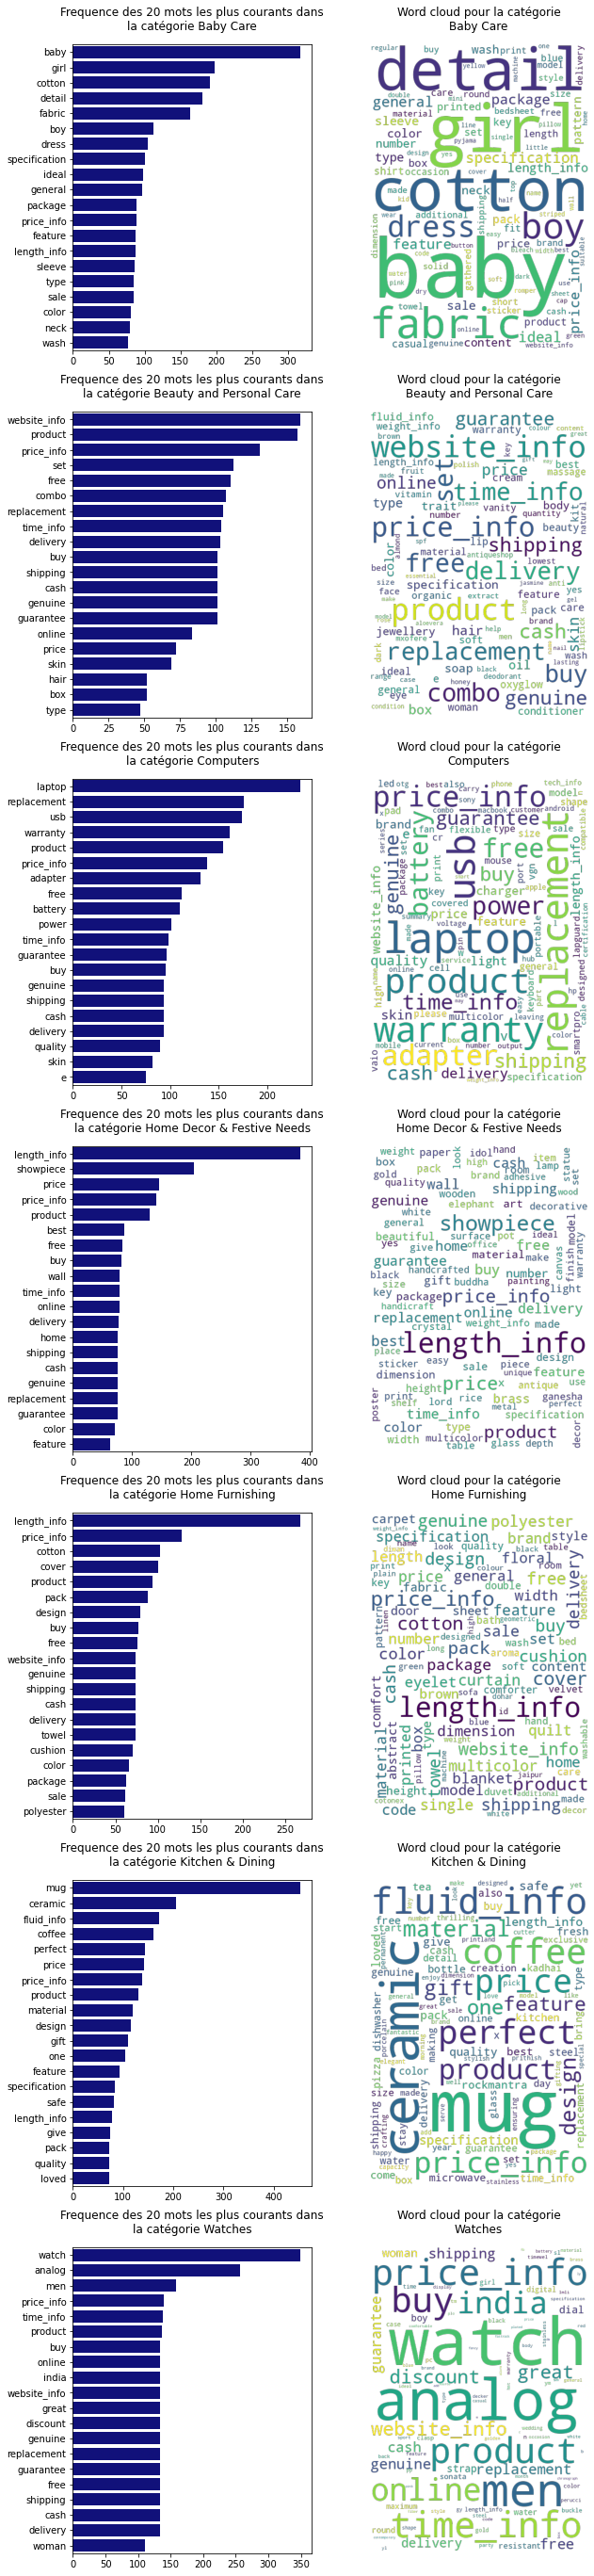

In [22]:
nrows = len(np.unique(categories))
wordcloud = WordCloud(width=500,
                      height=700,
                      mode='RGBA',
                      background_color=None,
                      contour_color='white',
                      max_words=100)
n_top = 20
k=1

fig = plt.figure(figsize=(2*5, nrows*7))

for cat in np.unique(categories):
    
    ax = fig.add_subplot(nrows,2,k)
    top_words = np.asarray(words_counter[cat].most_common(n_top)).T
    # Histogramme
    sns.barplot(y=top_words[0],
                x=top_words[1].astype(int),
                color='darkblue',
                ax=ax)
    ax.set_title(f"Frequence des {n_top} mots les plus courants dans\nla catégorie {cat}", pad=15)
    k+=1
    
    ax = fig.add_subplot(nrows,2,k)
    # Word cloud
    wordcloud.generate_from_frequencies(words_counter[cat])
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f"Word cloud pour la catégorie\n{cat}", pad=15)
    k+=1

fig.savefig('figures/words.png', bbox_inches='tight')
    
plt.show()

Les mots les plus fréquents pour chaque catégorie sont en ligne avec ce qui peut être attendu. Nous pouvons remarquer que les catégories risquent d'être difficiles à séparer sur cette base uniquement, certains mots apparaissant très fréquemment dans les deux catégories.

### 1.3.2. Visualisation des 2-gram les plus fréquents par catégorie

Nous pouvons également faire cette analyse sur les 2-gram.

In [23]:
bigrams_list = [list(nltk.bigrams(word_tokenize(sent))) for sent in bow_description]

In [24]:
def cat_bigrams_counter(categories_list, corpus):
    """Fonction de décompte des bigrams"""
    cat_bigrams_counter_dict = {}
    for cat in np.unique(categories_list):
        mapping = np.array(categories_list) == cat
        cat_corpus = corpus[mapping]
        bigrams_list = [list(nltk.bigrams(word_tokenize(text))) for text in cat_corpus]
        bigrams_list = [bigram for bigram_text in bigrams_list for bigram in bigram_text]
        cat_bigrams_counter_dict[cat] = collections.Counter(bigrams_list)
    return cat_bigrams_counter_dict

In [25]:
bigrams_counter = cat_bigrams_counter(categories, bow_description)

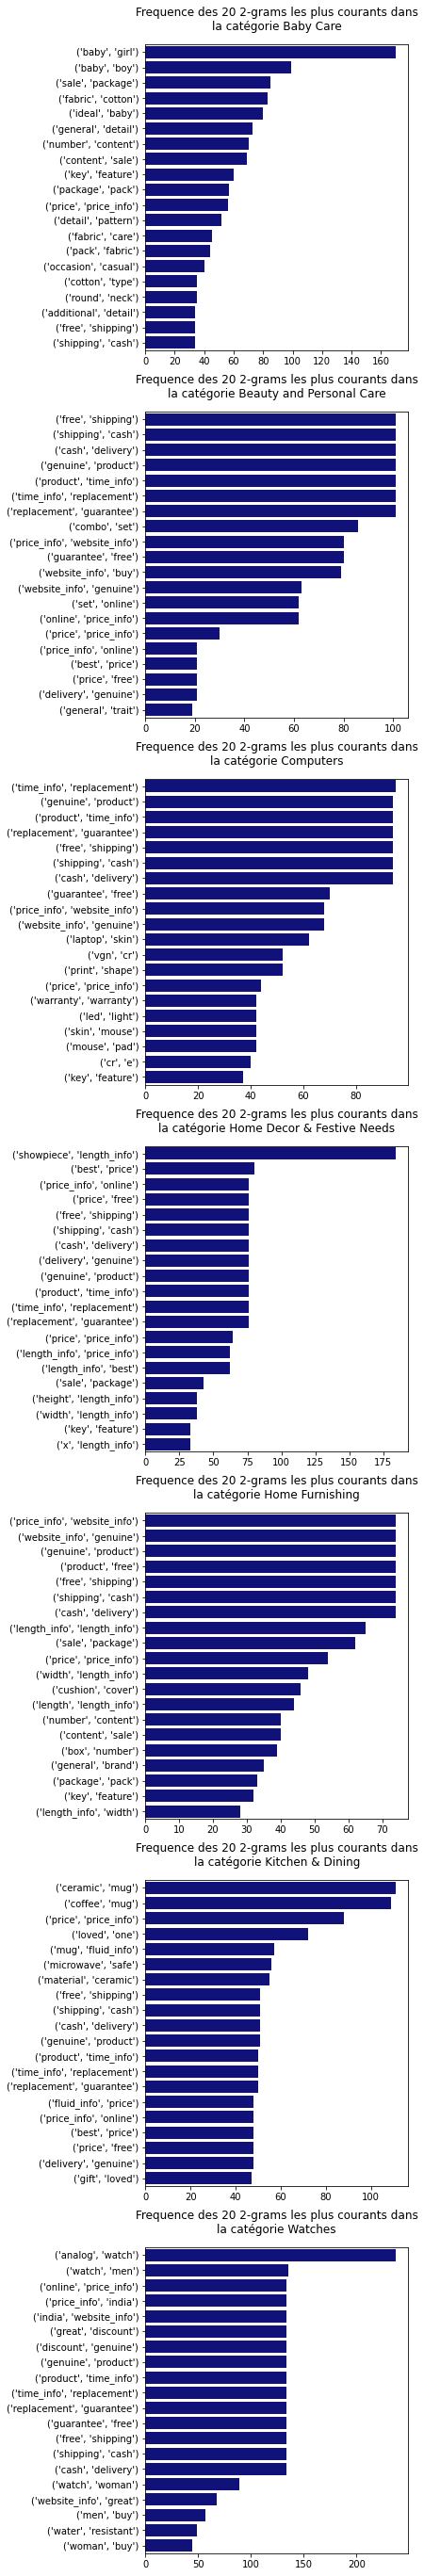

In [26]:
nrows = len(np.unique(categories))
n_top = 20
k=1

fig = plt.figure(figsize=(5, nrows*7))

for cat in np.unique(categories):
    
    ax = fig.add_subplot(nrows,1,k)
    top_words = np.asarray(bigrams_counter[cat].most_common(n_top), dtype=object).T
    sns.barplot(y=top_words[0],
                x=top_words[1].astype(int),
                color='darkblue',
                ax=ax)
    ax.set_title(f"Frequence des {n_top} 2-grams les plus courants dans\nla catégorie {cat}", pad=15)
    k+=1

plt.show()

## 1.4. Modèles textuels

Nous pouvons désormais passer à l'étape de clustering de texte.

Afin d'analyser si un clustering est possible, nous allons procéder par étapes:
- Réduction dimensionnelle au travers d'une PCA (ou SVD dans le cas de matrices sparse), en ne retenant que les dimensions expliquant 90% de la variance au total, permettant d'améliorer la performance des étapes suivantes et de réduire le bruit
- Etape de t-SNE en 2 dimensions, appliquée sur la base de dimension réduite
- K-Means appliqué sur la base en 2D, avec un nombre de clusters égal au nombre de catégories de produits
- Calcul de l'ARI entre catégories réelles et clusters

In [27]:
ari_txt = []

### 1.4.1. BOW et TF-IDF

Nous débutons par les approches simples de bag-of-word et TF-IDF.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import cluster, metrics
from sklearn import manifold, preprocessing
from functions import *

Nous appliquons les algorithmes de bag-of-word, puis tf-idf à notre base après pré-processing.

In [29]:
cvect = CountVectorizer(stop_words=en_sw, max_df=0.95, min_df=0.01)
ctf = TfidfVectorizer(stop_words=en_sw, min_df=0.01, use_idf=True)

cv_fit = cvect.fit(bow_description)
ctf_fit = ctf.fit(bow_description)

cv_transform = cvect.transform(bow_description)
ctf_transform = ctf.transform(bow_description)

Nous commençons par l'approche en bag-of-words.

In [30]:
ARI, X_tsne, labels = cluster_fct(cv_transform, categories, model_type='svd')

Etape de réduction dimensionnelle
102 features retenues, sur 500 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]


Perplexité retenue : 30
Finalisation


In [31]:
ari_txt.append({'model': 'BOW',
                'ARI': ARI})

ARI : 0.41525272203349634


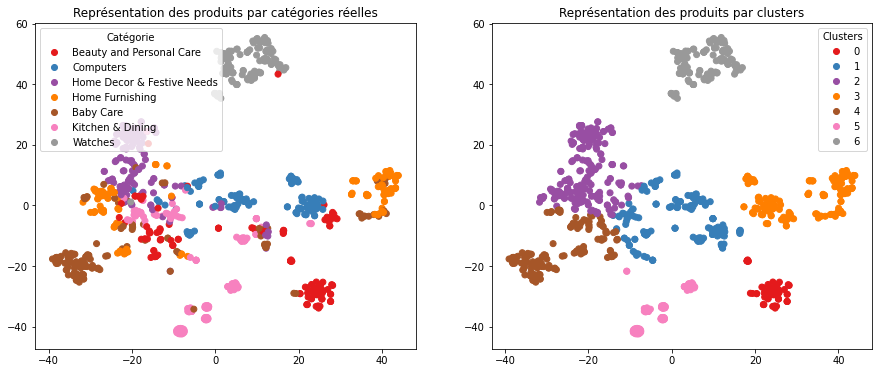

In [32]:
projected_plot(X_tsne, categories, labels, ARI)
plt.show()

Nous passons ensuite au TF-IDF.

In [33]:
ARI, X_tsne, labels = cluster_fct(ctf_transform, categories, model_type='svd')

Etape de réduction dimensionnelle
156 features retenues, sur 500 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


Perplexité retenue : 30
Finalisation


In [34]:
ari_txt.append({'model': 'TF-IDF',
                'ARI': ARI})

ARI : 0.4956994998783468


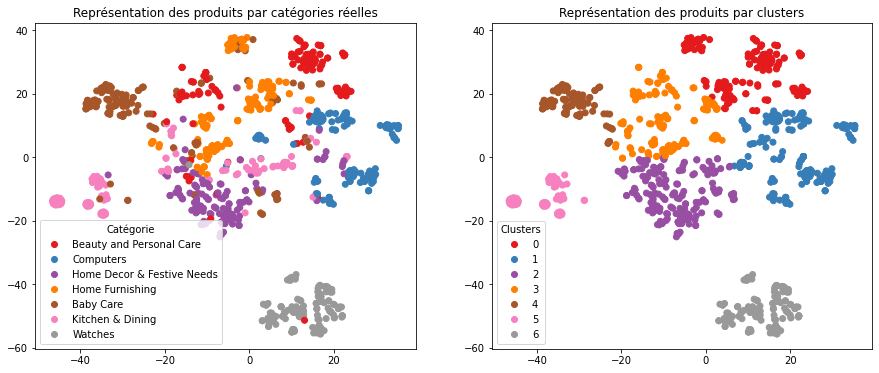

In [35]:
fig = projected_plot(X_tsne, categories, labels, ARI)
plt.show()
fig.savefig('figures/TFIDF_tsne.png', bbox_inches='tight')

### 1.4.2. Word2Vec et Doc2Vec

Nous passons désormais à deux approches basées sur un embedding: Word2Vec et Doc2Vec.

In [36]:
import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

Les algorithmes utilisés nécessitent d'adapter le préprocessing, en supprimant notamment la lemmatisation et le retrait de stop-words. 

In [37]:
def transform_w2v(text, features_map) :
    """Fonction de prétraitement adaptée à l'algorithme Word2Vec"""
    word_tokens = tokenize_with_features_add(text, features_map)    
    transf_desc_text = ' '.join(word_tokens)
    return transf_desc_text

In [38]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = None

In [39]:
w2v_description = text_data['description'].apply(lambda x: transform_w2v(x, features_map))
w2v_description.head()

0    key features of elegance polyester multicolor ...
1    specifications of sathiyas cotton bath towel b...
2    key features of eurospa cotton terry face towe...
3    key features of santosh royal fashion cotton p...
4    key features of jaipur print cotton floral kin...
Name: description, dtype: object

#### 1.4.2.1. Modèle Word2Vec

Nous commençons par le modèle Word2Vec.

In [40]:
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, 
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=3,
                                   workers=1)

In [41]:
sentences = w2v_description.to_list()
sentences = [word_tokenize(text) for text in sentences]

In [42]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print(f"Nombre de mots uniques : {len(w2v_words)}")

Nombre de mots uniques : 5234


In [43]:
import umap

In [44]:
model_vectors_list = np.asarray([model_vectors[i] for i in w2v_words])

In [45]:
umap_model = umap.UMAP(learning_rate=100, n_jobs=-1, random_state=1)
model_vectors_umap = umap_model.fit_transform(model_vectors_list)

In [46]:
n_sampled_words = 2
n_close_words = 3
sample_words = sample(model_vectors.index_to_key, n_sampled_words)

sample_close_words = []

for word in sample_words:
    close_words = model_vectors.most_similar(word, topn = n_close_words)
    sample_close_words.append(word)
    sample_close_words+=[close_word[0] for close_word in close_words]

sample_close_words_index = [model_vectors.get_index(word) for word in sample_close_words]

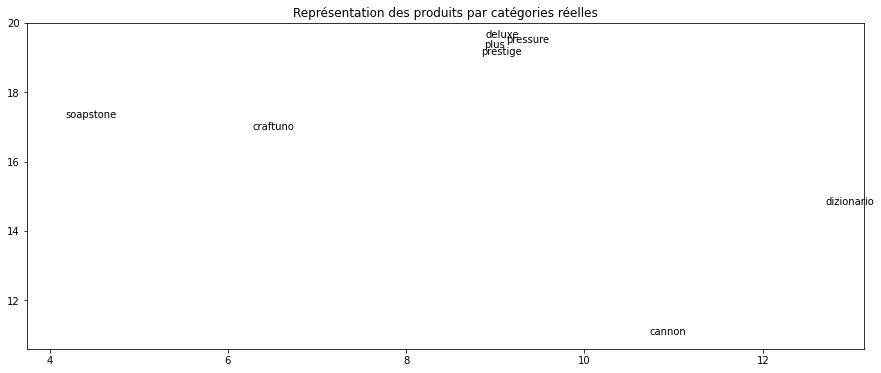

In [47]:
sample_close_words_coords = model_vectors_umap[sample_close_words_index]

fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(sample_close_words_coords[:,0],
           sample_close_words_coords[:,1],
           alpha=0
          )

for word, coords in zip(sample_close_words, sample_close_words_coords):
    ax.annotate(word,
                xy=(coords[0], coords[1]),
                xytext=(coords[0], coords[1])
              )

ax.set_title('Représentation des produits par catégories réelles')

plt.show()

In [48]:
max_sent_len = max([len(sent) for sent in sentences])

In [49]:
tokenizer = TextVectorization(standardize=None,
                              split='whitespace',
                              output_mode='int',
                              vocabulary=w2v_words,
                              output_sequence_length=max_sent_len)

In [50]:
len(tokenizer.get_vocabulary(False))

5234

In [51]:
sentences = w2v_description.to_list()

In [52]:
vocab = tokenizer.get_vocabulary()
word_index = [i for i in range(len(vocab))]
vocab_size = len(word_index)
embedding_matrix = np.zeros((vocab_size, w2v_size))
    
for word, idx in zip(vocab, word_index):
    if word in w2v_words:
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

print(f"Dimensions de la matrice d'embedding : {str(embedding_matrix.shape)}")

Dimensions de la matrice d'embedding : (5236, 300)


In [53]:
model = tf.keras.models.Sequential([
    tokenizer,
    Embedding(tokenizer.vocabulary_size(), w2v_size, weights=[embedding_matrix]),
    GlobalAveragePooling1D()
])

In [54]:
w2v_embeddings = model.predict(sentences)

33/33 [==============================] - 0s 5ms/step


In [55]:
ARI, X_tsne, labels = cluster_fct(w2v_embeddings, categories, model_type='pca')

Etape de réduction dimensionnelle
15 features retenues, sur 300 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.27s/it]


Perplexité retenue : 100
Finalisation


In [56]:
ari_txt.append({'model': 'Word2Vec',
                'ARI': ARI})

ARI : 0.3136136408155217


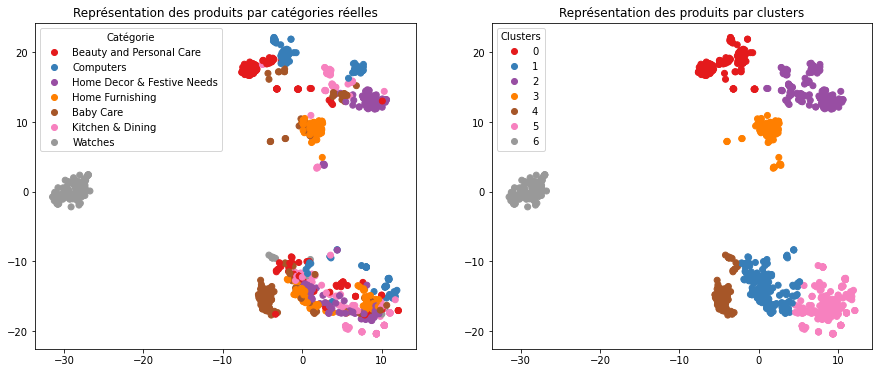

In [57]:
fig = projected_plot(X_tsne, categories, labels, ARI)
plt.show()
fig.savefig('figures/W2V_tsne.png', bbox_inches='tight')

#### 1.4.2.2. Modèle Doc2Vec

Nous passons désormais au modèle Doc2Vec.

In [58]:
sentences = w2v_description.to_list()
sentences = [word_tokenize(text) for text in sentences]

In [59]:
len([word for sent in sentences for word in sent])

76896

In [60]:
documents = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]

In [61]:
d2v_model = gensim.models.Doc2Vec(min_count=w2v_min_count,
                                  window=w2v_window,
                                  vector_size=w2v_size,
                                  seed=3,
                                  workers=1)

In [62]:
d2v_model.build_vocab(documents)
d2v_model.train(documents,
                total_examples=d2v_model.corpus_count,
                epochs=w2v_epochs)

In [63]:
model_vectors = d2v_model.dv
keys = model_vectors.index_to_key
model_vectors = np.array([model_vectors[i] for i in keys])

In [64]:
ARI, X_tsne, labels = cluster_fct(model_vectors, categories, model_type='pca')

Etape de réduction dimensionnelle
43 features retenues, sur 300 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.70s/it]


Perplexité retenue : 100
Finalisation


In [65]:
ari_txt.append({'model': 'Doc2Vec',
                'ARI': ARI})

ARI : 0.2213447161912709


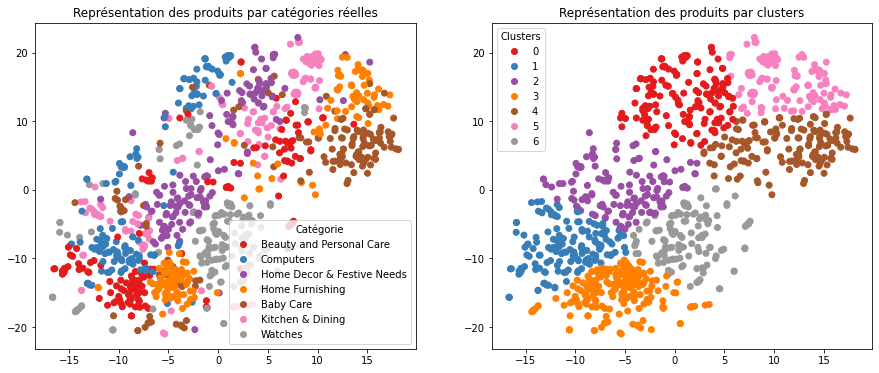

In [66]:
fig = projected_plot(X_tsne, categories, labels, ARI)
plt.show()

### 1.4.3. Modèle BERT

Nous allons désormais étudier un modèle en Transformer: le BERT.

In [67]:
from sentence_transformers import SentenceTransformer

In [68]:
model = SentenceTransformer('bert-base-uncased')

No sentence-transformers model found with name C:\Users\samue/.cache\torch\sentence_transformers\bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\samue/.cache\torch\sentence_transformers\bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Ce modèle nécessite de nouveau un pré-processing adapté.

In [69]:
def transform_dl_fct(text, features_map):
    """Fonction de pré-traitement adapté aux modèles avec tokenizer spécifique"""
    word_tokens = tokenize_with_features_add(text, features_map)
    transf_desc_text = ' '.join(word_tokens)
    return transf_desc_text

In [70]:
dl_description = text_data['description'].apply(lambda x: transform_dl_fct(x, features_map))
dl_description.head()

0    key features of elegance polyester multicolor ...
1    specifications of sathiyas cotton bath towel b...
2    key features of eurospa cotton terry face towe...
3    key features of santosh royal fashion cotton p...
4    key features of jaipur print cotton floral kin...
Name: description, dtype: object

In [71]:
embeddings = model.encode(dl_description)

In [72]:
ARI, X_tsne, labels = cluster_fct(embeddings, categories, model_type='pca')

Etape de réduction dimensionnelle
81 features retenues, sur 768 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.32s/it]


Perplexité retenue : 100
Finalisation


In [73]:
ari_txt.append({'model': 'BERT',
                'ARI': ARI})

ARI : 0.30375797753647243


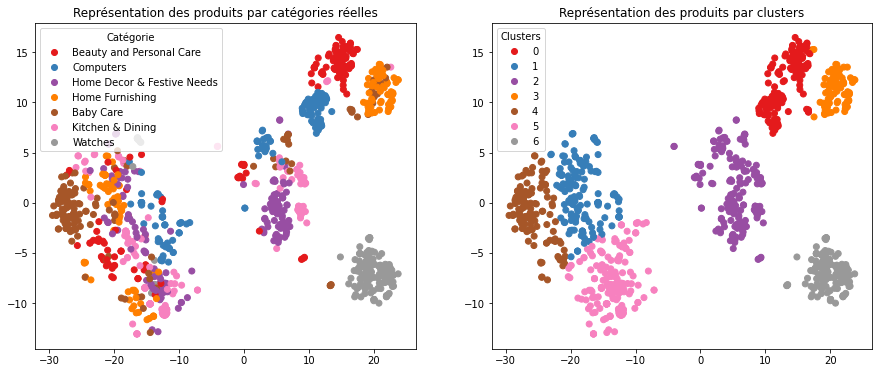

In [74]:
fig = projected_plot(X_tsne, categories, labels, ARI)
plt.show()
fig.savefig('figures/BERT_tsne.png', bbox_inches='tight')

### 1.4.4. USE - Universal Sentence Encoder

Nous étudions désormais un second modèle en Transformer: USE.

In [75]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [76]:
def feature_USE_fct(sentences, b_size):
    """
    Fonction d'embedding des coordonnées de chaque document par l'algorithme USE.
    """
    batch_size = min(b_size, len(sentences))

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    
    # Si la longueur du corpus n'est pas un multiple entier de batch_size, traitement des derniers éléments
    if idx+batch_size < len(sentences)-1:
        feat = embed(sentences[idx+batch_size:])
        features = np.concatenate((features,feat))
    
    return features

In [77]:
batch_size = 10
sentences = dl_description.to_list()

In [78]:
features_USE = feature_USE_fct(sentences, batch_size)

In [79]:
ARI, X_tsne, labels = cluster_fct(features_USE, categories, model_type='pca')

Etape de réduction dimensionnelle
117 features retenues, sur 512 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.44s/it]


Perplexité retenue : 30
Finalisation


In [80]:
ari_txt.append({'model': 'USE',
                'ARI': ARI})

ARI : 0.42487280139114036


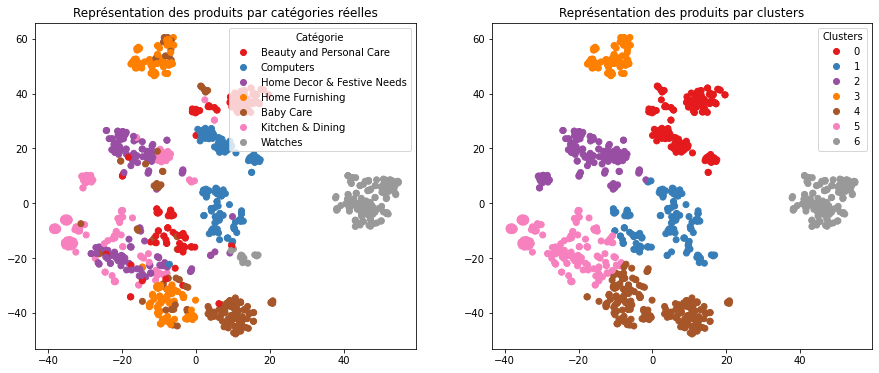

In [81]:
fig = projected_plot(X_tsne, categories, labels, ARI)
plt.show()
fig.savefig('figures/USE_tsne.png', bbox_inches='tight')

## 1.5. Choix du modèle

Nous pouvons désormais comparer les résultats obtenus sur nos différents modèles.

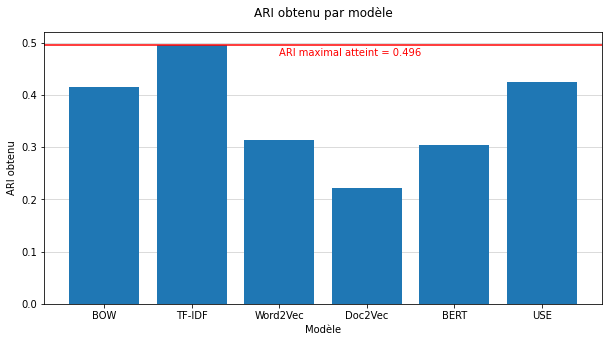

In [82]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(
    [x['model'] for x in ari_txt],
    [x['ARI'] for x in ari_txt]
)

ax.set_xlim(
    ax.get_xlim()[0],
    ax.get_xlim()[1]
)

ari_max = max(ari_txt, key=lambda x: x['ARI'])['ARI']

ax.hlines(
    ari_max,
    ax.get_xlim()[0],
    ax.get_xlim()[1],
    colors='r'
)

ax.text(
    x=2,
    y=ari_max-0.02,
    s=f'ARI maximal atteint = {ari_max:.3f}',
    color='r'
)

ax.set_title('ARI obtenu par modèle', pad=15)
ax.set_xlabel('Modèle')
ax.set_ylabel('ARI obtenu')
ax.grid(True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

fig.savefig('figures/ARI_txt.png', bbox_inches='tight')

plt.show()

Le modèle donnant le meilleur ARI se base sur les features extraites du modèle TF-IDF. Nous proposons donc de retenir celui-ci.

# 2. Clustering d'images

In [83]:
from PIL import Image, ImageOps
from io import BytesIO
import cv2 

Nous allons désormais étudier un clustering sur la base des images des produits.

Nous commençons par l'importation des données utiles (images, catégories, id produits).

In [84]:
images_bytes = []
image_id = []
with zipfile.ZipFile('Dataset+projet+prétraitement+textes+images.zip', 'r') as folder:
    for elem in folder.namelist():
        if elem.startswith('Flipkart/Images/') and elem != 'Flipkart/Images/':
            image_id.append(elem.replace("Flipkart/Images/", '').replace(".jpg", ''))
            img = folder.read(elem)
            images_bytes.append(BytesIO(img))     

In [85]:
# Ré-agencement des images dans le même ordre que les données de texte
mapping = [image_id.index(x) for x in text_data['uniq_id']]
images_bytes = [images_bytes[i] for i in mapping]

Notre évalution des modèles suivra les mêmes principes que pour les données textuelles.

In [86]:
ari_img = []

## 2.1. SIFT

Nous commençons par explorer un algorithme de SIFT.

In [87]:
# Conversion au format adapté aux étapes de préprocessing
images_jpeg = [Image.open(img) for img in images_bytes]

C:\Users\samue\DS\py_env\main\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### 2.1.1. Traitements préliminaires

Pour cet algorithme, notre préprocessing inclut :
- Passage en nuances de gris
- Correction du contraste
- Egalisation de l'histogramme

In [88]:
def img_preprocessing(img, gs=True):
    """
    Fonction de préprocessing des images:
    - nuances de gris (optionnel)
    - correction du contraste
    - égalisation
    """
    if gs == True:
        img_proc = ImageOps.grayscale(img)
    else:
        img_proc = img.copy()

    img_proc = ImageOps.autocontrast(img_proc)

    img_proc = ImageOps.equalize(img_proc)
    return img_proc

In [89]:
import tqdm

In [90]:
# Pré-traitement des images
images_proc = []
for img in tqdm.tqdm(images_jpeg):
    images_proc.append(img_preprocessing(img))

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:19<00:00, 54.03it/s]


In [91]:
images_gs = [np.array(img) for img in images_proc]

Nous pouvons désormais appliquer l'algorithme de SIFT aux images ainsi pré-traitées. Nous retenons 500 features maximum par image.

### 2.1.2. Création des bag of features

In [92]:
# Detection des feature points
descriptors = []
sift = cv2.SIFT_create(nfeatures=500)
for img in tqdm.tqdm(images_gs):
    keypoint, descriptor = sift.detectAndCompute(img, None)
    descriptors.append(descriptor.tolist())

del keypoint, descriptor
gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [03:58<00:00,  4.41it/s]


0

In [93]:
descriptors_flat = [desc for desc_list in descriptors for desc in desc_list]

Sur cette base, nous créons un bag-of-features, en appliquant un algorithme K-Means (en mini batch pour optimiser le processus sur notre machine) pour identifier les "features", qui seront les centroïdes identifiés.

In [94]:
from sklearn.cluster import MiniBatchKMeans

In [95]:
topics = list(set(categories))
n_topics = len(topics)

Pour identifier le nombre de clusters / features à retenir, nous allons regarder la fonction d'inertie sur différents nombre de clusters.

In [96]:
wgss = []
for n_feat_by_topic in tqdm.tqdm(np.arange(10, 90, 10, dtype=int)):
    n_clusters = n_topics*n_feat_by_topic
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(descriptors_flat)
    wgss.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:59<00:00,  7.38s/it]


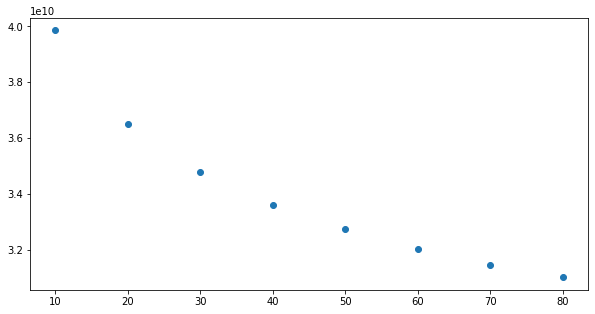

In [97]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(
    x=np.arange(10, 90, 10, dtype=int),
    y=wgss
)

plt.show()

In [98]:
n_feat_by_topic = 30
n_clusters = n_topics*n_feat_by_topic
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=1)
kmeans.fit(descriptors_flat)

MiniBatchKMeans(n_clusters=210, random_state=1)

In [99]:
bof_raw = [kmeans.predict(desc_list) for desc_list in descriptors]

Nous pouvons désormais créer la matrice d'embedding des images en bag-of-features.

In [100]:
del descriptors, descriptors_flat
gc.collect()

3219

In [101]:
from sklearn.preprocessing import Normalizer

In [102]:
bof = np.zeros((len(images_jpeg), n_clusters))

i=0
for row in bof_raw:
    for feature in row:
        bof[i, feature] += 1
    i += 1

norm = Normalizer()
bof = norm.fit_transform(bof)

In [103]:
from scipy import sparse

In [104]:
bof_sparse = sparse.coo_matrix(bof)

Nous procédons désormais comme pour le texte, en utilisant deux réductions dimensionnelles puis un clustering, et en évaluant l'ARI des clusters par rapport aux données réelles.

In [105]:
ARI, X_tsne, labels = cluster_fct(bof_sparse, categories, model_type='svd')

Etape de réduction dimensionnelle
96 features retenues, sur 210 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.49s/it]


Perplexité retenue : 30
Finalisation


In [106]:
ari_img.append({'model': 'SIFT',
                'ARI': ARI})

ARI : 0.08036799283060683


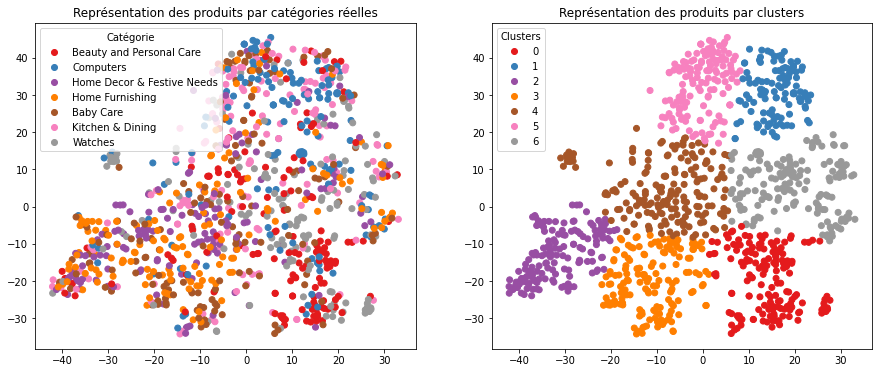

In [107]:
fig = projected_plot(X_tsne, categories, labels, ARI)
plt.show()
fig.savefig('figures/SIFT_tsne.png', bbox_inches='tight')

## 2.2. CNN

Nous passons enfin à une approche sur la base d'un algorithme de CNN. Nous utilisons le transfer learning pour bénéficier d'un algorithme pré-entraîné : le VGG-19.

In [108]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

Nous importons le modèle, en prenant soin de ne par inclure les trois derniers layers fully connected, sachant que notre but à ce stade est d'extraire des features.

In [109]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [110]:
# Extraction de features uniquement
for layer in vgg19.layers:
    layer.trainable = False

### 2.2.1. Traitements préliminaires

Cet algorithme nécessite un pré-traitement spécifique, notamment pour lui fournir des images dans la dimension attendue (224x224).

# Pré-traitement des images
images_proc_vgg19 = []
for img in tqdm.tqdm(images_jpeg):
    images_proc_vgg19.append(img_preprocessing(img, gs=False))

In [111]:
def vgg19_preprocessing(img):
    """
    Fonction de préprocessing spécifique pour le VGG19
    """
    img_proc = np.array(img_preprocessing(img, gs=False))
    img_proc = tf.image.resize(img_proc, size=(224,224))
    img_proc = preprocess_input(img_proc)
    return img_proc

In [112]:
images_vgg19 = np.array([vgg19_preprocessing(img) for img in tqdm.tqdm(images_jpeg)])

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:31<00:00, 33.50it/s]


### 2.2.2. Extraction des features

Nous extrayons les features à l'aide de l'algorithme vgg19 pré-entraîné sur le dataset ImageNet.

In [113]:
raw_coords = vgg19.predict(images_vgg19, batch_size=16)

66/66 [==============================] - 7s 82ms/step


In [114]:
raw_coords.shape

(1050, 7, 7, 512)

Ces features, au format (7x7x512) sont ensuite aplanies en un seul vecteur de dimension (1x25 088).

In [115]:
flat_coords = Flatten()(raw_coords)

In [116]:
flat_coords.shape

TensorShape([1050, 25088])

In [117]:
ARI, X_tsne, labels = cluster_fct(flat_coords, categories, model_type='pca')

Etape de réduction dimensionnelle
618 features retenues, sur 1,050 au total.
Etape de tSNE


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.49s/it]


Perplexité retenue : 100
Finalisation


In [118]:
ari_img.append({'model': 'VGG19',
                'ARI': ARI})

ARI : 0.4569442325092577


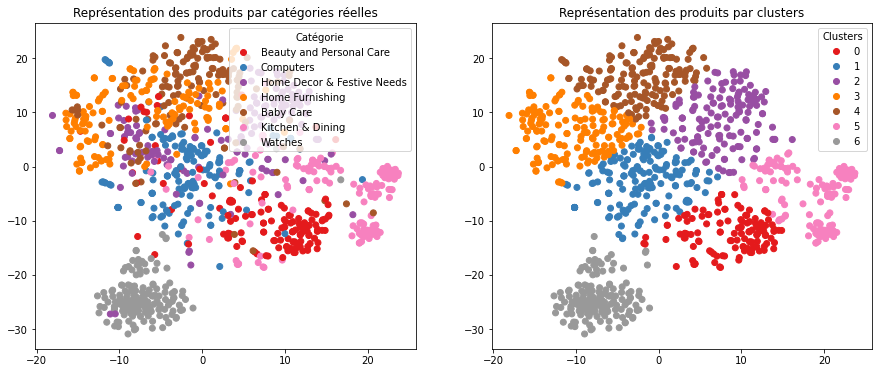

In [119]:
fig = projected_plot(X_tsne, categories, labels, ARI)
plt.show()
fig.savefig('figures/VGG19_tsne.png', bbox_inches='tight')

In [120]:
del raw_coords, images_vgg19
gc.collect()

8104

## 2.3. Choix du modèle

Nous pouvons désormais comparer les résultats obtenus sur nos différents modèles.

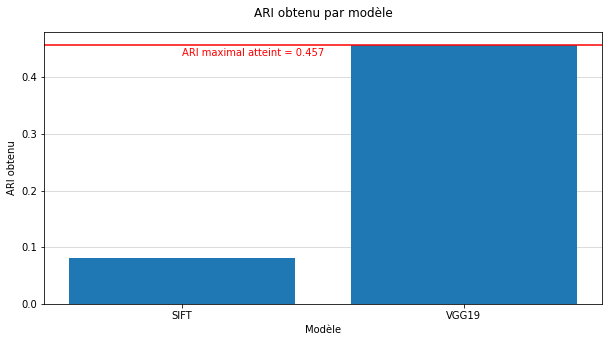

In [121]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(
    [x['model'] for x in ari_img],
    [x['ARI'] for x in ari_img]
)

ax.set_xlim(
    ax.get_xlim()[0],
    ax.get_xlim()[1]
)

ari_max = max(ari_img, key=lambda x: x['ARI'])['ARI']

ax.hlines(
    ari_max,
    ax.get_xlim()[0],
    ax.get_xlim()[1],
    colors='r'
)

ax.text(
    x=0,
    y=ari_max-0.02,
    s=f'ARI maximal atteint = {ari_max:.3f}',
    color='r'
)

ax.set_title('ARI obtenu par modèle', pad=15)
ax.set_xlabel('Modèle')
ax.set_ylabel('ARI obtenu')
ax.grid(True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

fig.savefig('figures/ARI_img.png', bbox_inches='tight')

plt.show()

Nous constatons que les features extraites du modèle VGG19 permettent d'obtenir le meilleur ARI.

# 3. Test de combinaison de modèles en SVM

## 3.1. Entraînement sur données de texte

In [122]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

Nous définissons deux sets : entraînement et test, ce dernier correspondant à 20% des données, avec stratification sur les catégories de produits.

Les algorithmes seront entraînés sur le set d'entraînement, en optimisant les hyperparamètres éventuels grâce à une évaluation croisée en 3 folds.

Les probabilités associées à chaque catégorie seront ensuite extraite et sommées sur le set de test, et la catégorie ayant la valeur maximale sera retenue. L'algorithme combiné sera ensuite évalué sur cette prédiction, en utilisant l'accuracy score, et au travers d'une matrice de confusion globale.

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([bow_description, images_jpeg]).T,
    categories,
    test_size=.2,
    stratify=categories,
    random_state=25)

C:\Users\samue\AppData\Local\Temp\ipykernel_17932\3283243219.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([bow_description, images_jpeg]).T,


Afin d'utiliser des pipelines propres, nous créons une classe correspondant à la première réduction dimensionnelle (PCA ou SVD) utilisée précédemment lors des calculs d'ARI.

In [124]:
class dim_reduction():
    
    def __init__(self, model_type, explained_var_target=1):
        assert model_type in ['svd', 'pca'], ("Le modèle doit être de type 'svd', ou 'pca'")
        assert (0 < explained_var_target <= 1),\
        ("Le ratio de variance doit être compris entre 0 et 1, ou bien None pour un choix manuel")
        
        self.model_type = model_type
        self.explained_var_target = explained_var_target
        return None
    
    def fit(self, X, y=None):
 
        if self.model_type == 'svd':
            
            # Réduction dimensionnelle au travers d'une SVD (méthode adaptée aux inputs sparse)
            self.model = decomposition.TruncatedSVD(random_state=1,
                                                    n_components=min(X.shape))
            self.model.fit(X)
            explained_var = self.model.explained_variance_ratio_.cumsum()
            self.n_components = sum(explained_var <= self.explained_var_target)
            self.model.set_params(**{'n_components': self.n_components})

        elif self.model_type == 'pca':
            
            # Réduction dimensionnelle au travers d'une ACP
            self.model = decomposition.PCA(random_state=1,
                                           n_components=self.explained_var_target)
            self.model.fit(X)
            self.n_components = self.model.n_components_

        else:
            raise Exception("Modèle de réduction dimensionnelle non reconnu.")        
        
        # Normalisation des données, le SVD ne résultant pas en des vecteurs normalisés
        norm = preprocessing.Normalizer()
        self.model = pipeline.Pipeline([('decomp_model', self.model), ('normalizer', norm)])
        self.model.fit(X)
        
        return self
        
    def transform(self, X):
        return self.model.transform(X)
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [125]:
ctf = TfidfVectorizer(stop_words=en_sw, min_df=0.01, use_idf=True)
txt_dim_r = dim_reduction('svd', .9)
txt_svc = SVC(probability=True)

In [126]:
txt_classifier = Pipeline([('TF-IDF', ctf),
                           ('dim_red', txt_dim_r),
                           ('SVC', txt_svc)])
txt_classifier

Pipeline(steps=[('TF-IDF',
                 TfidfVectorizer(min_df=0.01,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('dim_red',
                 <__main__.dim_reduction object at 0x000001DF0B087250>),
                ('SVC', SVC(probability=True))])

In [127]:
params = {
    'SVC__C': [0.1, 1, 10]
}
gs_txt = GridSearchCV(txt_classifier, params, cv=3, verbose=1, refit=False)

In [128]:
gs_txt.fit(X_train[:,0], y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('TF-IDF',
                                        TfidfVectorizer(min_df=0.01,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('dim_red',
                                        <__main__.dim_reduction object at 0x000001DF0B087250>),
                                       ('SVC', SVC(probability=True))]),
             param_grid={'SVC__C': [0.1, 1, 10]}, refit=False, verbose=1)

In [129]:
txt_classifier.set_params(**gs_txt.best_params_)

Pipeline(steps=[('TF-IDF',
                 TfidfVectorizer(min_df=0.01,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('dim_red',
                 <__main__.dim_reduction object at 0x000001DF0B087250>),
                ('SVC', SVC(C=10, probability=True))])

In [130]:
txt_classifier.fit(X_train[:,0], y_train)

Pipeline(steps=[('TF-IDF',
                 TfidfVectorizer(min_df=0.01,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('dim_red',
                 <__main__.dim_reduction object at 0x000001DF0B087250>),
                ('SVC', SVC(C=10, probability=True))])

## 3.2. Entraînement sur données d'images

Nous commençons par ajouter l'étape de Flatten() au modèle VGG19 importé.

In [131]:
inputs = vgg19.input
vgg_step = vgg19.output
features = Flatten()(vgg_step)
vgg_model = Model(inputs, features)

Toujours dans le but d'utiliser des pipelines, nous transformons ce modèle en une classe utilisable avec méthode fit_predict().

In [132]:
class img_model():
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.model = vgg_model
        return self
    
    def transform(self, X):
        return self.model.predict(X)
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [133]:
vgg19_model = img_model()
img_dim_r = dim_reduction('pca', .9)
img_svc = SVC(probability=True)

In [134]:
img_classifier = Pipeline([('VGG19', vgg19_model),
                           ('dim_red', img_dim_r),
                           ('SVC', img_svc)])
img_classifier

Pipeline(steps=[('VGG19', <__main__.img_model object at 0x000001DF076268B0>),
                ('dim_red',
                 <__main__.dim_reduction object at 0x000001DF07594AC0>),
                ('SVC', SVC(probability=True))])

In [135]:
X_train_preproc = np.array([vgg19_preprocessing(img) for img in tqdm.tqdm(X_train[:,1])])
X_test_preproc = np.array([vgg19_preprocessing(img) for img in tqdm.tqdm(X_test[:,1])])

100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:04<00:00, 50.61it/s]


In [136]:
params = {
    'SVC__C': [0.1, 1, 10]
}
gs_img = GridSearchCV(img_classifier, params, cv=3, refit=False)

In [137]:
gs_img.fit(X_train_preproc, y_train)

9/9 [==============================] - 1s 137ms/step


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('VGG19',
                                        <__main__.img_model object at 0x000001DF076268B0>),
                                       ('dim_red',
                                        <__main__.dim_reduction object at 0x000001DF07594AC0>),
                                       ('SVC', SVC(probability=True))]),
             param_grid={'SVC__C': [0.1, 1, 10]}, refit=False)

In [138]:
gs_img.best_params_

{'SVC__C': 10}

In [139]:
img_classifier.set_params(**gs_img.best_params_)

Pipeline(steps=[('VGG19', <__main__.img_model object at 0x000001DF076268B0>),
                ('dim_red',
                 <__main__.dim_reduction object at 0x000001DF07594AC0>),
                ('SVC', SVC(C=10, probability=True))])

In [140]:
img_classifier.fit(X_train_preproc, y_train)

27/27 [==============================] - 4s 152ms/step


Pipeline(steps=[('VGG19', <__main__.img_model object at 0x000001DF076268B0>),
                ('dim_red',
                 <__main__.dim_reduction object at 0x000001DF07594AC0>),
                ('SVC', SVC(C=10, probability=True))])

## 3.3. Combinaison des deux modèles

Nous combinons désormais les prédictions des deux modèles pour obtenir notre prédiction, sur le test de set.

In [141]:
proba_pred_test_txt = txt_classifier.predict_proba(X_test[:,0])
proba_pred_test_img = img_classifier.predict_proba(X_test_preproc)
proba_pred_test = proba_pred_test_txt + proba_pred_test_img

7/7 [==============================] - 2s 268ms/step


In [142]:
cat_uniques = txt_classifier.classes_

In [143]:
y_pred_test_txt = txt_classifier.predict(X_test[:,0])
y_pred_test_img = img_classifier.predict(X_test_preproc)
y_pred_test = np.array([cat_uniques[i] for i in np.argmax(proba_pred_test, axis=1)])

7/7 [==============================] - 1s 138ms/step


In [144]:
acc_score = accuracy_score(y_test, y_pred_test_txt)
print(f"Le modèle textuel résulte en une accuracy de {acc_score:.3f} sur le set de test.")

acc_score = accuracy_score(y_test, y_pred_test_img)
print(f"Le modèle image résulte en une accuracy de {acc_score:.3f} sur le set de test.")

acc_score = accuracy_score(y_test, y_pred_test)
print(f"Le modèle combiné résulte en une accuracy de {acc_score:.3f} sur le set de test.")

Le modèle textuel résulte en une accuracy de 0.914 sur le set de test.
Le modèle image résulte en une accuracy de 0.829 sur le set de test.
Le modèle combiné résulte en une accuracy de 0.905 sur le set de test.


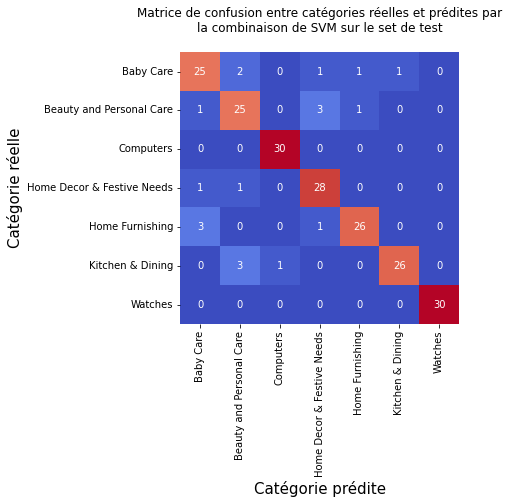

In [145]:
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize = (5,5))

sns.heatmap(
    cm,
    cmap='coolwarm',
    vmin=0,
    annot=True,
    fmt='d',
    xticklabels=cat_uniques,
    yticklabels=cat_uniques,
    cbar=False
)

ax.set_xlabel('Catégorie prédite', fontsize=15)
ax.set_ylabel('Catégorie réelle', fontsize=15)
ax.set_title("Matrice de confusion entre catégories réelles et prédites par\n\
la combinaison de SVM sur le set de test",
             pad=20)

fig.savefig('figures/confusion_mat.png', bbox_inches='tight')

plt.show()